# DO2021: Eksamensprojekt kode
*Af Anders Reinholdt Sindberg & Albert Neve Alsbjerg*

## Indholdsfortegnelse
1. Indledning
2. Web Scraping: Hent og behandling af punktligheds-data fra DSB's hjemmeside
3. Web Scraping: Hent og behandling af punktligheds-data fra Banedanmarks hjemmeside
4. Behandling af togpunktlighedsdata på Københavns Hovedbanegård

## Indledning
**`Note: Dette er bare udkast til indledning. Når vi har overblikket kan vi skrive det ordenligt (og tilføje til listen over data vi bruger) `**

Både DSB og Banedanmark har et mål om at forbedre punktligheden. Dertil foreslår Banedanmark en “forenkling” af Københavns Hovedbanegård, der indebære en ombygning af togsporene.

Hvorfor er det først efter 23 år med store problemer med punktligheden og store udgifter på KBH, at banedanmark foreslår en løsningsplan på?

Denne notebook vil gennemgå kode og dataanalyse nødvendig til at belyse ovenstående. Det kræver følgende data:
* Historisk data over togpunktlighed på Hovedbanegården
* Nuværende omkostninger 
* Simuleringsdata over gevinster ved forenkling af Hovedbanegården

### Klargøring
Til behandling af vores data vil vi bruge følgende biblioteker:
- **pandas** til [...]
- **numpy** til matematiske funktioner
- **requests** til at forbinde til en webside
- **beautifulsoup** og **regex** til parsing af data fra web scraping.
- **matplotlib** til at plotte og illustrere data
- **time** til at formindske fejl i koden


In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

## Togpunktlighed: Web scraping fra DSB
Historisk data over togpunktlighed og kompensationsgrad hentes fra DSB's hjemmeside.

Ved at inspicere hjemmesiden kan det ses, at data'en er opdelt i måned og år. Yderligere er data'en opdelt efter strækning, hvor der på hver strækning findes data for mål for kundepunktligheden, den faktiske punktlighed og kompensationen i procent.

Dette data vil blive hentet og gemt i et dataframe.

### Den relevante data lokeres i html fra hjemmesiden
Ved brug af `requests`og `beautifulsoup` vil hjemmesidens html data blive hentet og parset, hvorefter den relevante data vil blive gemt i et `pandas` dataframe.

Først hentes html fra den relevante side hos DSB og gemmes med `beautifulsoup`. Derefter printes html, så hjemmesidens opbygning kan aflæses og den relevante data kan lokeres:

In [2]:
# URL til data'en på DSB's hjemmeside indlæses, hentes, og gemmes som beautifulsoup objekt:
url = "https://www.dsb.dk/find-produkter-og-services/dsb-rejsetidsgaranti/dsb-pendler-rejsetidsgaranti/kompensationsstorrelse/trafikdata-for-fr---ny/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

#html data printes og inspiceres
soup


<!DOCTYPE html>

<!--[if lt IE 8 ]>				<html class="ie lt-ie8 lt-ie9 lt-ie10 no-js" lang="da"> <![endif]-->
<!--[if IE 8 ]>					<html class="ie ie8 lt-ie9 lt-ie10 no-js" lang="da"> <![endif]-->
<!--[if IE 9 ]>					<html class="ie ie9 lt-ie10 no-js" lang="da"> <![endif]-->
<!--[if (gt IE 9)|!(IE)]><!-->
<html class="no-js" lang="da">
<!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1.0, maximum-scale=1.0" name="viewport"/>
<meta content="telephone=no" name="format-detection"/>
<title>
        DSB | Trafikdata for Fjern- og regionaltog - kundepunktlighed
    </title>
<meta content="Her finder du trafikdata for kundepunktligheden på din strækning opgjort på månedsbasis. Se din kompensationsgrad her." id="PageDescriptionID" name="description"/>
<script id="dsb-cached-fonts" type="text/javascript">
        !function(a){"use strict";function c(a,b,c){a.addEventListener?a.addEventListener(b

Ved at inspicere html data kan det ses, at html'en er opdelt i sektioner af måned og år. Yderligere er disse sektioner opdelt efter togstrækning, hvor der på hver strækning findes data for mål for kundepunktligheden, den faktiske punktlighed og kompensationen i procent.

For at kunne navigere i html data'en, vil en lister over hver sektion af år blive gemt. Ved at inspicere ovenstående html ses det yderligere, at disse gemmes i en `section` med `class` kaldet `customer-service__contact`:

In [3]:
year_sections = soup.find_all('section', attrs={'class':'customer-service__contact'})

#eksempel html på seneste år printes:
year_sections[0]

<section class="customer-service__contact">
<div>
<div class="container">
<h2 class="text--title--h2">
                    2021
                </h2>
</div>
</div>
<div class="customer-service__contact-info show-all--open" style="display: block">
<div class="container">
<div class="customer-service__contact-info-table">
<div class="customer-service__contact-info-column"><div><section>
<div class="contentblock background-white inline-campaign">
<div class="container">
<div class="inline-campaign__content">
<div class="inline-campaign__title">
<h2>
                            November
                        </h2>
</div>
<div class="inline-campaign__body text--wysiwyg">
<table border="1" style="height: 324px;">
<tbody>
<tr style="height: 18px;">
<td style="height: 18px; width: 190.8px;"><strong>Strækning</strong></td>
<td style="height: 18px; width: 186.8px;"><strong>Mål for kundepunktlighed</strong></td>
<td style="height: 18px; width: 64.4px;"><strong>November 21</strong></td>
<td styl

#### Årstal
Under hver sektion af år gemmes selve årstallet som tekst i en header `h2` med `class` `text--title--h2`. Dog gemmes denne `string` med tomme linjer før og efter, som skal fjernes. 

Nedenfor ses eksempel:

In [4]:
# eksempel på udtræk af årstal:
year_sections[0]\
        .find('h2',attrs={'class':'text--title--h2'})\
        .text\
        .replace("\r\n","")\
        .strip()

'2021'

#### Måned
Under hvert år findes en række sektioner af månedsdata i en hver sin `div` container kaldet `inline-campaign__content`. Et eksempel på dette følger: 

In [5]:
# eksempel på html-udtræk på seneste opgjorte måned i 2021:
year_sections[0].find_all('div', attrs={'class':'inline-campaign__content'})[0]

<div class="inline-campaign__content">
<div class="inline-campaign__title">
<h2>
                            November
                        </h2>
</div>
<div class="inline-campaign__body text--wysiwyg">
<table border="1" style="height: 324px;">
<tbody>
<tr style="height: 18px;">
<td style="height: 18px; width: 190.8px;"><strong>Strækning</strong></td>
<td style="height: 18px; width: 186.8px;"><strong>Mål for kundepunktlighed</strong></td>
<td style="height: 18px; width: 64.4px;"><strong>November 21</strong></td>
<td style="height: 18px; width: 114px;"><strong>Kompensation</strong></td>
</tr>
<tr style="height: 18px;">
<td style="height: 18px; width: 190.8px;">København -  Roskilde</td>
<td headers="N1002A" style="height: 18px; width: 186.8px;">86,8%</td>
<td headers="N1002E" style="height: 18px; width: 64.4px;">75,2%</td>
<td headers="N10033" style="height: 18px; width: 114px;">12,0%</td>
</tr>
<tr style="height: 18px;">
<td style="height: 18px; width: 190.8px;">København -  Kalundbo

Hertil kan det aflæses, at måneden som tekst kan findes i noden `h2` og at denne ligeledes som årstallet gemmes som en string med tomme linjer før og efter, som skal fjernes.

Et eksempel på dette følger:

In [6]:
#eksempel på udtræk af måned i tekst
year_sections[0]\
    .find_all('div', attrs={'class':'inline-campaign__content'})[0]\
    .find('h2')\
    .text\
    .replace("\r\n","")\
    .strip()

'November'

#### Strækning
Det er nu muligt at finde de relevante data på de enkelte strækinger. Det kan af ovenstående html udledes, at den ønskede data gemmes i en node `tr`. Disse er hver række i den ønskede data. Den første række indeholder overskrifter og må derfor springes over.

Et eksempel på html-udtræk af første strækning følger:

In [7]:
year_sections[0]\
        .find_all('div', attrs={'class':'inline-campaign__content'})\
        [0]\
        .find_all('tr')[1]

<tr style="height: 18px;">
<td style="height: 18px; width: 190.8px;">København -  Roskilde</td>
<td headers="N1002A" style="height: 18px; width: 186.8px;">86,8%</td>
<td headers="N1002E" style="height: 18px; width: 64.4px;">75,2%</td>
<td headers="N10033" style="height: 18px; width: 114px;">12,0%</td>
</tr>

#### Udtræk af data
Det er nu muligt at få den ønskede data hentet ud. Det kan udledes, at af ovenstående node `tr` har fire *children* af noden `td`. Disse indeholder i rækkefølge:
1. Navn på strækning
2. Mål for kundepunktlighed
3. Den faktiske punktlighed på strækningen i det pågældende år og måned
4. Kompensation i procent

Nedenfor følger et eksempel på hvordan disse data hentes ud:

In [8]:
# eksempel udtræk fra september 2021
test_okt21 = year_sections[0]\
                .find_all('div', attrs={'class':'inline-campaign__content'})\
                [0]\
                .find_all('tr')[1]\
                .find_all('td')

print("Eksempel udtræk:")
print("Strækning: " + test_okt21[0].text)
print("Mål for punktlighed: " + test_okt21[1].text)
print("Faktisk punktlighed: " + test_okt21[2].text)
print("Kompensation: " + test_okt21[3].text)

Eksempel udtræk:
Strækning: København -  Roskilde
Mål for punktlighed: 86,8%
Faktisk punktlighed: 75,2%
Kompensation: 12,0%


### Eksport til dataframe
Ovenstående gør det nu muligt at udtrække data'en og gemme i et dataframe. Den data, der ønskes udtrækket, er følgende:
- Årstal
- Måned
- Mål for kundepunktlighed
- Den faktiske punktlighed på strækningen
- Kompensation i procent

Dette gemmes i et samlet dataframe.

In [9]:
#initiér tid til debug
start_time = time.time()

#en tom liste oprettes for hvert af de ønskede data, der hver skal have sin egen kolonne i dataframet
year = []
month = []
train_line = []
goal = []
actual = []
compensation = []

#midlertiddige variable på årstal & måned oprettes til brug i loop
this_year = ""
this_month = ""

#et loop startes for hvert sektion af år på hjemmesiden 
#disse er allerede hentet og gemt i en liste kaldet year_sections
for i in range(len(year_sections)):
    #årstalet gemmes
    this_year = year_sections[i]\
                    .find('h2',attrs={'class':'text--title--h2'})\
                    .text\
                    .replace("\r\n","")\
                    .strip()
    
    #en liste over hver måned for pågældende år
    month_sections = year_sections[i].find_all('div', attrs={'class':'inline-campaign__content'})
    
    #hver måned loopes igennem
    for j in range (len(month_sections)):
        #måneden gemmes
        this_month = month_sections[j]\
                        .find('h2')\
                        .text\
                        .replace("\r\n","")\
                        .strip()
        
        #Det er nu muligt at loope yderligere gennem hver strækning
        #en liste over toglinjer defineres
        line_sections = month_sections[j].find_all('tr')
        
        #disse loopes igennem, hvor første springes over, da denne indholder kolonne navne
        for k in range (len(line_sections)-1):
            #det er nu muligt at udtrække den ønskede data
            #disse ligger i 4 children under toglinjen, som gemmes i en liste:
            data_sections = line_sections[k+1].find_all('td')
            
            #dataen kan nu gemmes
            year.append(this_year)
            month.append(this_month)
            train_line.append(data_sections[0].text)
            goal.append(data_sections[1].text)
            actual.append(data_sections[2].text)
            compensation.append(data_sections[3].text)
                

#DataFrame konstrueres
df_punktlighed = pd.DataFrame({'Årstal':year,
                               'Måned':month,
                               'Togstrækning':train_line,
                               'Målsætning':goal,
                               'Punktlighed':actual,
                               'Kompensation':compensation})
#tid printes
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 0.26 seconds ---


Dataframet er nu konstrueret, og inspiceres:

In [10]:
df_punktlighed

,Årstal,Måned,Togstrækning,Målsætning,Punktlighed,Kompensation
0,2021,November,København - Roskilde,"86,8%","75,2%","12,0%"
1,2021,November,København - Kalundborg,"86,8%","74,2%","13,0%"
2,2021,November,København - Nykøbing F,"86,8%","86,8%","0,0%"
3,2021,November,Køge - Næstved,"86,8%","93,1%","0,0%"
4,2021,November,København - Odense,"86,8%","62,2%","25,0%"
...,...,...,...,...,...,...
1750,2014,Januar,Odder - Aarhus - Grenaa,95%,"96,7%",99%
1751,2014,Januar,DSB Øresund,Mål for rettidighed,Januar 14,-
1752,2014,Januar,København - Helsingør,"92,0%","94,6%",-
1753,2014,Januar,København - CPH Lufthavn,"92,0%","91,5%",-


#### Fjern af årstal
Det ses dog, at i årene 2014 og 2015 blev togpunktligheden opgjort på anden vis end de efterfølgende år. Dette er ikke blot en formatændring. Derfor er det ikke muligt at sammenligne 2014 og 2015 med de øvrige år og de må derfor fjernes:

In [11]:
#liste med årstal der skal fjernes:
del_years = ["2014", "2015"]

#årstalene fjernes fra dataframe'et
df_punktlighed = df_punktlighed[df_punktlighed.Årstal.isin(del_years) == False]

#dataframe printes
df_punktlighed

,Årstal,Måned,Togstrækning,Målsætning,Punktlighed,Kompensation
0,2021,November,København - Roskilde,"86,8%","75,2%","12,0%"
1,2021,November,København - Kalundborg,"86,8%","74,2%","13,0%"
2,2021,November,København - Nykøbing F,"86,8%","86,8%","0,0%"
3,2021,November,Køge - Næstved,"86,8%","93,1%","0,0%"
4,2021,November,København - Odense,"86,8%","62,2%","25,0%"
...,...,...,...,...,...,...
1270,2016,Januar,Aalborg - Frederikshavn,"81,8%","94,1%","0,0%"
1271,2016,Januar,Odder - Aarhus - Grenaa,"81,8%","90,9%","0,0%"
1272,2016,Januar,København - Helsingør,"81,8%","73,1%","9,0%"
1273,2016,Januar,København - CPH Lufthavn,"81,8%","78,2%","4,0%"


#### Omkod af årstal
Årstalene omkodes fra string til int:

In [12]:
df_punktlighed["Årstal"] = df_punktlighed["Årstal"].astype(int)

<ipython-input-12-90ae0ce28e11>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_punktlighed["Årstal"] = df_punktlighed["Årstal"].astype(int)


#### Omkodning af procent
Rækkerne med procent omkodes til float, så der kan regnes på procenterne.

Der dog enkelte slå fejl i den data som er hentet fra DSB's hjemmeside:

In [13]:
print(df_punktlighed[(df_punktlighed == '69,4,%').any(axis=1)])
print(df_punktlighed[(df_punktlighed == '76,3,%').any(axis=1)])
print(df_punktlighed[(df_punktlighed == '74,7,%').any(axis=1)])
print(df_punktlighed[(df_punktlighed == '77,3,%').any(axis=1)])

    Årstal Måned         Togstrækning Målsætning Punktlighed Kompensation
72    2021  Juli  København -  Odense      86,8%      69,4,%        18,0%
    Årstal Måned         Togstrækning Målsætning Punktlighed Kompensation
89    2021  Juni  København -  Odense      86,8%      76,3,%        11,0%
     Årstal Måned         Togstrækning Målsætning Punktlighed Kompensation
106    2021   Maj  København -  Odense      86,8%      74,7,%        13,0%
     Årstal  Måned         Togstrækning Målsætning Punktlighed Kompensation
123    2021  April  København -  Odense      86,8%      77,3,%        10,0%


Fejlene rettes manuelt:

In [14]:
df_punktlighed.at[72, "Punktlighed"] = '69,4%'
df_punktlighed.at[89, "Punktlighed"] = '76,3%'
df_punktlighed.at[106, "Punktlighed"] = '74,7%'
df_punktlighed.at[123, "Punktlighed"] = '77,3%'

Der ses også, at i en enkelt strækning i 2018 blev indsat togbusser, hvorfor togpunktlighed ikke kunne måles.

In [15]:
df_punktlighed[(df_punktlighed == '\xa0-').any(axis=1)]

,Årstal,Måned,Togstrækning,Målsætning,Punktlighed,Kompensation
724,2018,Juli,København - Helsingør*,"82,9%",-,-


Denne række fjernes fra vores data:

In [16]:
df_punktlighed = df_punktlighed.drop(index=724)

Der ses dog stadig rækker, som indeholder indtastningsfejl. Disse fejl omfatter:
- Linjeskift
- Mellemrum

Disse fjernes også fra indtastningerne.

Rækkerne med procent kan nu omkodes til floats, og dermed procenter:

In [17]:
# Liste over kolonnenavne
omkod_list = ["Målsætning", "Punktlighed", "Kompensation"]

#df_test = df_punktlighed.copy()

# Hver kolonne loopes igennem og omkodes til float:
for i in range(len(omkod_list)):
    df_punktlighed[omkod_list[i]] = df_punktlighed[omkod_list[i]].\
                                                        str.\
                                                        replace('\n', '').\
                                                        str.\
                                                        replace('\xa0', '').\
                                                        str.\
                                                        rstrip('%').\
                                                        str.\
                                                        replace(',', '.').\
                                                        astype('float') / 100.0

df_punktlighed

,Årstal,Måned,Togstrækning,Målsætning,Punktlighed,Kompensation
0,2021,November,København - Roskilde,0.868,0.752,0.12
1,2021,November,København - Kalundborg,0.868,0.742,0.13
2,2021,November,København - Nykøbing F,0.868,0.868,0.00
3,2021,November,Køge - Næstved,0.868,0.931,0.00
4,2021,November,København - Odense,0.868,0.622,0.25
...,...,...,...,...,...,...
1270,2016,Januar,Aalborg - Frederikshavn,0.818,0.941,0.00
1271,2016,Januar,Odder - Aarhus - Grenaa,0.818,0.909,0.00
1272,2016,Januar,København - Helsingør,0.818,0.731,0.09
1273,2016,Januar,København - CPH Lufthavn,0.818,0.782,0.04


#### Navn på togstrækninger
Det indtastede navn for hver enkelt togstrækning indeholder også fejl. Disse fejl omfatter:
- Dobbelt mellemrum

Disse fejl vil nu blive rettet

In [18]:
#dobbelt mellemrum fjernes
df_punktlighed["Togstrækning"] = df_punktlighed["Togstrækning"].\
                                                                str.\
                                                                replace(' ', '').\
                                                                str.\
                                                                replace('\xa0', '')

#### Måneder
Under kolonnen "Måned" er december i 2018 ikke blot indtastet som "December", men "December 2018". Dette er den eneste måned med denne fejl, så her fjernes 2018 fra string:

In [19]:
df_punktlighed["Måned"] = df_punktlighed["Måned"].\
                                                str.\
                                                replace(' 2018', '')

### Beregninger
Dataframet er nu konstrueret og vi kan nu begynder at foretage beregninger.

### Divergens fra målsætning
Den faktiske punktlighed fratrækkes målet for punktlighed, for at skabe en mål afvigelsen af togpunktligheden:

#### Afvigelse på tværs af år

In [20]:
df_punktlighed["Afvigelse"] = df_punktlighed["Punktlighed"]-df_punktlighed["Målsætning"]
df_punktlighed

,Årstal,Måned,Togstrækning,Målsætning,Punktlighed,Kompensation,Afvigelse
0,2021,November,København-Roskilde,0.868,0.752,0.12,-0.116
1,2021,November,København-Kalundborg,0.868,0.742,0.13,-0.126
2,2021,November,København-NykøbingF,0.868,0.868,0.00,0.000
3,2021,November,Køge-Næstved,0.868,0.931,0.00,0.063
4,2021,November,København-Odense,0.868,0.622,0.25,-0.246
...,...,...,...,...,...,...,...
1270,2016,Januar,Aalborg-Frederikshavn,0.818,0.941,0.00,0.123
1271,2016,Januar,Odder-Aarhus-Grenaa,0.818,0.909,0.00,0.091
1272,2016,Januar,København-Helsingør,0.818,0.731,0.09,-0.087
1273,2016,Januar,København-CPHLufthavn,0.818,0.782,0.04,-0.036


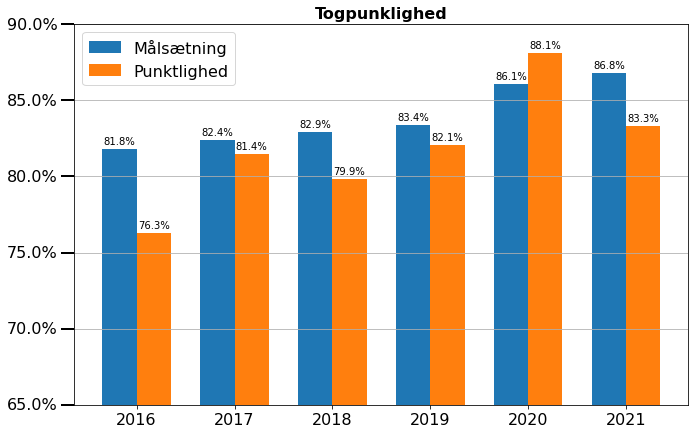

In [21]:
split_vars = ['Årstal'] 
apply_vars = ['Målsætning', 'Punktlighed', 'Kompensation']
apply_fcts = ['mean']

df_illu = df_punktlighed.groupby(split_vars)[apply_vars].agg(apply_fcts)

x_labels = df_illu.index.get_level_values(0)
l_mål = list(df_illu['Målsætning']['mean'])
l_punkt = list(df_illu['Punktlighed']['mean'])


values1 = np.array(l_mål)
values2 = np.array(l_punkt)
x = np.arange(len(x_labels))

n_values = 2
width = 0.35

# plot
fig, ax = plt.subplots(figsize=(11,7))
rects1 = ax.bar(x-width/2, l_mål, width, label='Målsætning')
rects2 = ax.bar(x+width/2, l_punkt, width, label='Punktlighed')
#ax.bar(x, values1, width, color='b')
#ax.bar(x+width, values2, width, color='g')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
        
# x-aksen
x_ticks = []
for i in range(len(x_labels)):
    x_ticks.append(i)
plt.xticks(x_ticks, x_labels, \
           fontsize='16', \
           horizontalalignment='center', \
           verticalalignment='top')

# y-aksen
plt.yticks(
          fontsize='16', \
          horizontalalignment='right', \
          verticalalignment='center')
plt.tick_params(axis='y', direction='out', length=13, width=2)

# zoom ind
plt.ylim([0.65, 0.9])

# omdan y-aksen til procent
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# tilføj grid
plt.grid(axis = 'y')

# tilføj titel
ax.set_title('Togpunklighed', \
             fontweight='bold', \
             fontsize='16')

# tilføj legend
plt.legend(loc="upper left", prop={'size': 16})

#### Afvigelse på tværs af kvartaler
Et variabel for kvartal indsættes i datasættet:

In [22]:
# funktion oprettes til formålet:
q1 = ['Januar', 'Februar', 'Marts']
q2 = ['April', 'Maj', 'Juni']
q3 = ['Juli', 'August', 'September']
q4 = ['Oktober', 'November', 'December']

def calc_quarter(row):
    month = row["Måned"]
    year = str(row['Årstal'])
    if any(month in m for m in q1):
        return year + " Q1"
    if any(month in m for m in q2):
        return year + " Q2"
    if any(month in m for m in q3):
        return year + " Q3"
    if any(month in m for m in q4):
        return year + " Q4"

# funktionen køres på dataframe og gemmes i ny kolonne
df_punktlighed["Kvartal"] = df_punktlighed.apply(calc_quarter, axis=1)

# inspiceres
df_punktlighed

,Årstal,Måned,Togstrækning,Målsætning,Punktlighed,Kompensation,Afvigelse,Kvartal
0,2021,November,København-Roskilde,0.868,0.752,0.12,-0.116,2021 Q4
1,2021,November,København-Kalundborg,0.868,0.742,0.13,-0.126,2021 Q4
2,2021,November,København-NykøbingF,0.868,0.868,0.00,0.000,2021 Q4
3,2021,November,Køge-Næstved,0.868,0.931,0.00,0.063,2021 Q4
4,2021,November,København-Odense,0.868,0.622,0.25,-0.246,2021 Q4
...,...,...,...,...,...,...,...,...
1270,2016,Januar,Aalborg-Frederikshavn,0.818,0.941,0.00,0.123,2016 Q1
1271,2016,Januar,Odder-Aarhus-Grenaa,0.818,0.909,0.00,0.091,2016 Q1
1272,2016,Januar,København-Helsingør,0.818,0.731,0.09,-0.087,2016 Q1
1273,2016,Januar,København-CPHLufthavn,0.818,0.782,0.04,-0.036,2016 Q1


Punktlighed og målsætning for hvert kvartal plottes.

Nedenfor eksempel for år 2018:

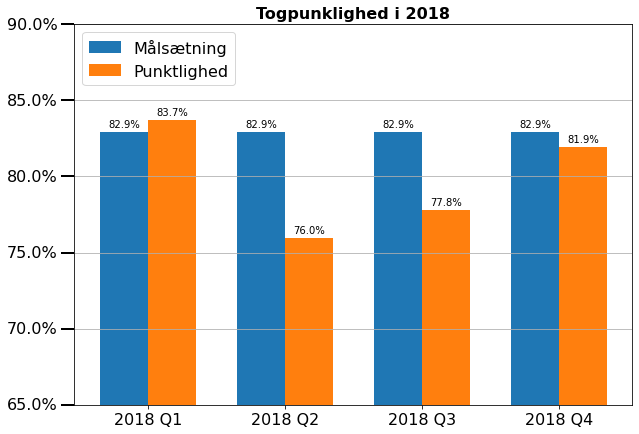

In [23]:
split_vars = ['Kvartal'] 
apply_vars = ['Målsætning', 'Punktlighed']
apply_fcts = ['mean']

df_temp = df_punktlighed[df_punktlighed["Årstal"]==2018]
df_illu = df_temp.groupby(split_vars)[apply_vars].agg(apply_fcts)

x_labels = df_illu.index.get_level_values(0)
l_mål = list(df_illu['Målsætning']['mean'])
l_punkt = list(df_illu['Punktlighed']['mean'])


values1 = np.array(l_mål)
values2 = np.array(l_punkt)
x = np.arange(len(x_labels))

width = 0.35

# plot
fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x-width/2, l_mål, width, label='Målsætning')
rects2 = ax.bar(x+width/2, l_punkt, width, label='Punktlighed')

# funktion der tilføjer procent over søjlerne
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
        
# x-aksen
x_ticks = []
for i in range(len(x_labels)):
    x_ticks.append(i)
plt.xticks(x_ticks, x_labels, \
           fontsize='16', \
           horizontalalignment='center', \
           verticalalignment='top')

# y-aksen
plt.yticks(
          fontsize='16', \
          horizontalalignment='right', \
          verticalalignment='center')
plt.tick_params(axis='y', direction='out', length=13, width=2)

# zoom ind
plt.ylim([0.65, 0.9])

# omdan y-aksen til procent
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# tilføj grid
plt.grid(axis = 'y')

# tilføj titel
ax.set_title('Togpunklighed i 2018', \
             fontweight='bold', \
             fontsize='16')

# tilføj legend
plt.legend(loc="upper left", prop={'size': 16})

## Togpunktlighed: Web scrape fra Banedanmark
Historisk data over togpunktlighed og kompensation hentes fra ligeledes fra Banedanmarks's hjemmeside.

Ved at inspicere hjemmesiden kan det ses, at data'en er opdelt i måned og år. Yderligere er der data på hvem er henholdsvis Banedanmark, DSB eller eksterne forhold, der har ansvaret for, at et tog ikke kom til tiden.

Dette data vil blive hentet og gemt i et dataframe

### Den relevante data lokores i html fra hjemmeside
Ved brug af requestsog beautifulsoup vil hjemmesidens html data blive hentet og parset, hvorefter den relevante data vil blive gemt i et pandas dataframe.

Hvert år har sin egen url.

Først hentes html fra den relevante side hos Banedanmark og gemmes med beautifulsoup. Derefter printes html, så hjemmesidens opbygning kan aflæses og den relevante data kan lokeres:

In [24]:
# URL til data'en på Banedanmark's hjemmeside indlæses, hentes, og gemmes som beautifulsoup objekt:
# i eksemplet her bruges år 2021
url = "https://www.bane.dk/da/Om-Banedanmark/Saadan-koerer-togene/Fjernbanen-2021"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

#html data printes og inspiceres
soup


<!DOCTYPE HTML>

<html lang="da">
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<script data-culture="DA" id="CookieConsent" src="https://policy.app.cookieinformation.com/uc.js" type="text/javascript"></script>
<!-- Google Tag Manager -->
<script>
(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':
	new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],
	j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;
	j.setAttribute('data-category-consent', 'cookie_cat_statistic');
	j.setAttribute('data-consent-src', 'https://www.googletagmanager.com/gtm.js?id=' + i + dl);
	f.parentNode.insertBefore(j, f);
	})(window,document,'script','dataLayer','GTM-P4BBKVR');</script>
<!-- End Google Tag Manager -->
<link href="/-/design/dist/global/styles/print---b5d14345.css" rel="stylesheet" type="text/css"/>
<link href="/-/design/dist/global/styles/rte---e43289

Sektionen der indeholder den tabel med den ønskede data kan nu lokaliseres:

In [25]:
table_sections = soup.find_all('table')

# eksempel på tabel:
table_sections[0]

<table style="height: 108px; width: 961.6px;">
<tbody>
<tr>
<td style="text-align: left;">Punktlighed<br/>
            DSB 2021</td>
<td style="text-align: left;">Kundepunktlighed DSB 2021<br/>
            (mål 78,7 %)<br/>
</td>
<td style="text-align: left;">Banedanmarks ansvar<br/>
            (Max. 9,0 %)</td>
<td style="text-align: left;">Jernbanevirksomhedens ansvar</td>
<td style="text-align: left;">Eksterne forhold</td>
</tr>
<tr>
<td style="text-align: left;">januar</td>
<td style="text-align: left;">88,5 %</td>
<td style="text-align: left;">5,6 %</td>
<td style="text-align: left;">3,5 %</td>
<td style="text-align: left;"> 2,4 %</td>
</tr>
<tr>
<td style="text-align: left;">februar</td>
<td style="text-align: left;">84,8 %</td>
<td style="text-align: left;">7,6 %</td>
<td style="text-align: left;">4,2 % </td>
<td style="text-align: left;">3,4 % </td>
</tr>
<tr>
<td style="text-align: left;">marts</td>
<td style="text-align: left;">87,4 % </td>
<td style="text-align: left;">5,7 

Da det kun er øveste tabel der indeholder data med DSB, ses der bort fra de øvrige.

Hver række i tabellen kan nu lokeres:

In [26]:
bane_rows = table_sections[0].find_all('tr')

# eksempel inspiceres:
bane_rows[1]

<tr>
<td style="text-align: left;">januar</td>
<td style="text-align: left;">88,5 %</td>
<td style="text-align: left;">5,6 %</td>
<td style="text-align: left;">3,5 %</td>
<td style="text-align: left;"> 2,4 %</td>
</tr>

Den første række indeholder overskrifter til kolonner, og kan derfra springes over, når data hentes.

Den ønskede data kan nu hentes ud. Eksempel følger:

In [27]:
ex_data = bane_rows[1].find_all('td')

print('Måned: ' + ex_data[0].text)
print('Punktlighed: ' + ex_data[1].text)
print('Banedanmarks ansvar: ' + ex_data[2].text)
print('DSB\'s ansvar: ' + ex_data [3].text)
print('Eksterne forhold: ' + ex_data[4].text)

Måned: januar
Punktlighed: 88,5 %
Banedanmarks ansvar: 5,6 %
DSB's ansvar: 3,5 %
Eksterne forhold:  2,4 %


### Eksport til dataframe
Ovenstående gennemgang gør det nu muligt, at eksportere til et dataframe.

Til det formel oprettes et loop, der henter data fra hvert år (som har en unik url).

Den data der ønskes udtrækket, er følgende:
- Årstal
- Måned
- Punktlighed
- Banedanmarks ansvar
- DSB's ansvar
- Eksterne forhold

In [28]:
#initiér tid til debug
start_time = time.time()

#en tom liste oprettes for hvert af de ønskede data, der hver skal have sin egen kolonne i dataframet
year = []
month = []
punktlighed = []
banedk_a = []
dsb_a = []
ekstern_a = []

# en liste over de år, der skal indhentes data fra:
year_list = [2016, 2017, 2018, 2019, 2020, 2021]

# et loop startes for hvert år
for i in range(len(year_list)):
    # årstallet gemmes
    this_year = year_list[i]
    
    # url til data, hvor årstal ændres:
    url = 'https://www.bane.dk/da/Om-Banedanmark/Saadan-koerer-togene/Fjernbanen-' + str(this_year)
    
    # BeautifulSoup objekt af siden gemmes:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # tabellen med den ønskede data lokaliseres:
    table = soup.find('table')
    
    # en liste over data rækkerne kan nu findes:
    table_rows = table.find_all('tr')
    
    # hver række kan nu loopes igennem, hvor første springes over:
    for j in range(len(table_rows)-1):
        # en liste over den ønskede data i den pågælde række kan nu hentes:
        data_list = table_rows[j+1].find_all('td')
        
        # data kan nu hentes til listen
        year.append(this_year)
        month.append(data_list[0].text)
        punktlighed.append(data_list[1].text)
        banedk_a.append(data_list[2].text)
        dsb_a.append(data_list[3].text)
        ekstern_a.append(data_list[4].text)
    

# DataFramet kan nu konstrueres:
df_ansvar = pd.DataFrame({'Årstal':year,
                          'Måned':month,
                          'Punktlighed':punktlighed,
                          'Banedanmarks ansvar':banedk_a,
                          'DSB\'s ansvar':dsb_a,
                          'Eksterne forhold':ekstern_a})

#tid printes
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 7.01 seconds ---


Dataframet er konstrueret, og kan nu inspiceres:

In [29]:
df_ansvar

,Årstal,Måned,Punktlighed,Banedanmarks ansvar,DSB's ansvar,Eksterne forhold
0,2016,januar,"75,5 %","10,6 %","10,6 %","3,3 %"
1,2016,februar,"80,2 %","7,0 %","9,1 %","3,8 %"
2,2016,marts,"73,6 %","13,2 %","9,2 %","4,0 %"
3,2016,april,"73,5 %","10,9 %","10,9 %","4,7 %"
4,2016,maj,"65,6 %","18,8 %","10,2 %","5,4 %"
...,...,...,...,...,...,...
65,2021,juni,"81,9 %","7,9 %","5,9 %","4,3 %"
66,2021,juli,"73,7 %","12,8 %","7,3 %","6,2 %"
67,2021,august,"76,8 %","76,8 %","11,3 %","6,5 %"
68,2021,september,"81,6 %","8,2 %","5,4 %","4,8 %"


### Omkodning af procent
Rækkerne med procent omkodes til float, så der kan regnes på procenterne.

In [30]:
# Liste over kolonnenavne
omkod_list = ["Punktlighed", "Banedanmarks ansvar", "DSB\'s ansvar", "Eksterne forhold"]

#df_test = df_punktlighed.copy()

# Hver kolonne loopes igennem og omkodes til float:
for i in range(len(omkod_list)):
    df_ansvar[omkod_list[i]] = df_ansvar[omkod_list[i]].\
                                                        str.\
                                                        replace('&nbsp;', '').\
                                                        str.\
                                                        replace('\xa0', '').\
                                                        str.\
                                                        rstrip('%').\
                                                        str.\
                                                        replace(',', '.').\
                                                        astype('float') / 100.0

df_ansvar

,Årstal,Måned,Punktlighed,Banedanmarks ansvar,DSB's ansvar,Eksterne forhold
0,2016,januar,0.755,0.106,0.106,0.033
1,2016,februar,0.802,0.070,0.091,0.038
2,2016,marts,0.736,0.132,0.092,0.040
3,2016,april,0.735,0.109,0.109,0.047
4,2016,maj,0.656,0.188,0.102,0.054
...,...,...,...,...,...,...
65,2021,juni,0.819,0.079,0.059,0.043
66,2021,juli,0.737,0.128,0.073,0.062
67,2021,august,0.768,0.768,0.113,0.065
68,2021,september,0.816,0.082,0.054,0.048


### Sammenligning af ansvar på tværs af år
Sammenliging af den gennemsnittelig procent for ansvar på tværs af årene:

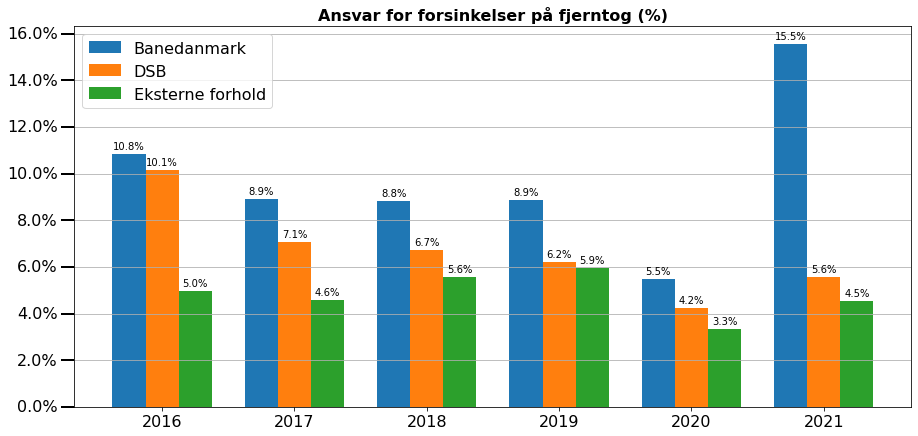

In [31]:
split_vars = ['Årstal'] 
apply_vars = ['Banedanmarks ansvar', 'DSB\'s ansvar', 'Eksterne forhold']
apply_fcts = ['mean']

df_illu = df_ansvar.groupby(split_vars)[apply_vars].agg(apply_fcts)

x_labels = df_illu.index.get_level_values(0)
l_banedk = list(df_illu['Banedanmarks ansvar']['mean'])
l_dsb = list(df_illu['DSB\'s ansvar']['mean'])
l_ekstern = list(df_illu['Eksterne forhold']['mean'])

values1 = np.array(l_banedk)
values2 = np.array(l_dsb)
values3 = np.array(l_ekstern)
x = np.arange(len(x_labels))

width = 0.25

# plot
fig, ax = plt.subplots(figsize=(15,7))
rects1 = ax.bar(x-width, values1, width, label='Banedanmark')
rects2 = ax.bar(x, values2, width, label='DSB')
rects3 = ax.bar(x+width, values3, width, label='Eksterne forhold')

# funktion der tilføjer tekst med procent over søjlerne i diagrammet
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
        
# x-aksen
x_ticks = []
for i in range(len(x_labels)):
    x_ticks.append(i)
plt.xticks(x_ticks, x_labels, \
           fontsize='16', \
           horizontalalignment='center', \
           verticalalignment='top')

# y-aksen
plt.yticks(
          fontsize='16', \
          horizontalalignment='right', \
          verticalalignment='center')
plt.tick_params(axis='y', direction='out', length=13, width=2)

# omdan y-aksen til procent
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# tilføj grid
plt.grid(axis = 'y')

# tilføj titel
ax.set_title('Ansvar for forsinkelser på fjerntog (%)', \
             fontweight='bold', \
             fontsize='16')

# tilføj legend
plt.legend(loc="upper left", prop={'size': 16})

## Togpunktlighed: Københavns Hovedbanegård
Banedanmark har udleveret data over togpunktligheden på Københavns Hovedbangård i perioden 2015-2019. Disse importeres:

In [32]:
#datasættet importeres fra excel fil
df_kbh = pd.read_excel("Udtræk fra TAO v2 til studenter.xlsx",\
                       usecols="A:B",\
                       names=["Dato", "Togpunktlighed"],\
                       sheet_name="Punktlighedstal for KH")
#inspiceres
df_kbh.head(5)

,Dato,Togpunktlighed
0,2015-01-01,83.3
1,2015-02-01,82.9
2,2015-03-01,87.0
3,2015-04-01,83.3
4,2015-05-01,78.1


### Datamanipulering
Punktligheden omskrives til procent. Årstal, kvartal og måned tilføjes. 

In [33]:
# punktlighed omskrives til procent
df_kbh["Togpunktlighed"] = df_kbh["Togpunktlighed"]/100

# årstal tilføjes
df_kbh["Årstal"] = df_kbh["Dato"].dt.year

# kvartal tilføjes
def calc_quarter(date):
    return str(date.year) + " Q" + str(date.quarter)
df_kbh["Kvartal"] = df_kbh["Dato"].apply(calc_quarter)

# Måned tilføjes
def calc_month(date):
    month_list = ['Januar', 'Februar', 'Marts', 'April', 'Maj', 'Juni', 'Juli', 'August', 'September', 'Oktober',' November', 'December']
    n_month = date.month
    return month_list[n_month-1]
df_kbh["Måned"] = df_kbh["Dato"].apply(calc_month)

#inspiceres
df_kbh.head(13)

,Dato,Togpunktlighed,Årstal,Kvartal,Måned
0,2015-01-01,0.833,2015,2015 Q1,Januar
1,2015-02-01,0.829,2015,2015 Q1,Februar
2,2015-03-01,0.870,2015,2015 Q1,Marts
3,2015-04-01,0.833,2015,2015 Q2,April
4,2015-05-01,0.781,2015,2015 Q2,Maj
5,2015-06-01,0.771,2015,2015 Q2,Juni
6,2015-07-01,0.805,2015,2015 Q3,Juli
7,2015-08-01,0.781,2015,2015 Q3,August
8,2015-09-01,0.801,2015,2015 Q3,September
9,2015-10-01,0.800,2015,2015 Q4,Oktober


#### Illustration
Togpunktligheden på Københavns Hovedbanegård illustreres. Først per år, dernæst per kvartal.

Text(0.5, 1.0, 'Togpunktlighed på Københavns Hovedbanegård')

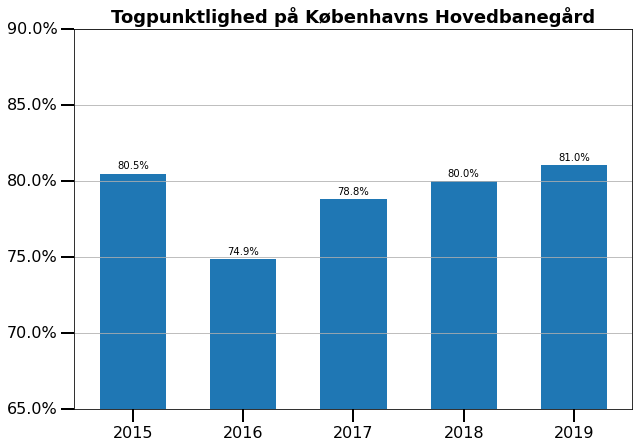

In [34]:
split_vars = ['Årstal'] 
apply_vars = ['Togpunktlighed']
apply_fcts = ['mean']

df_illu = df_kbh.groupby(split_vars)[apply_vars].agg(apply_fcts)

x_labels = df_illu.index.get_level_values(0)
l_punkt = list(df_illu['Togpunktlighed']['mean'])

values = np.array(l_punkt)
x = range(len(values))

# plot
fig, ax = plt.subplots(figsize=(10,7))
rects = ax.bar(x, values, 0.6)

# labels på bar
for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# x-aksen
x_ticks = []
for i in range(len(x_labels)):
    x_ticks.append(i)
plt.xticks(x_ticks, x_labels, \
           rotation=0, \
           fontsize='16', \
           horizontalalignment='center', \
           verticalalignment='top')
plt.tick_params(axis='x', direction='out', length=13, width=2)

# y-aksen
plt.yticks(
          fontsize='16', \
          horizontalalignment='right', \
          verticalalignment='center')
plt.tick_params(axis='y', direction='out', length=13, width=2)

# zoom ind
plt.ylim([0.65, 0.9])

# tilføj grid
plt.grid(axis = 'y')

# omdan y-aksen til procent
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# tilføj titel
ax.set_title('Togpunktlighed på Københavns Hovedbanegård', \
             fontweight='bold', \
             fontsize='18')

Text(0.5, 1.0, 'Togpunktlighed på Københavns Hovedbanegård')

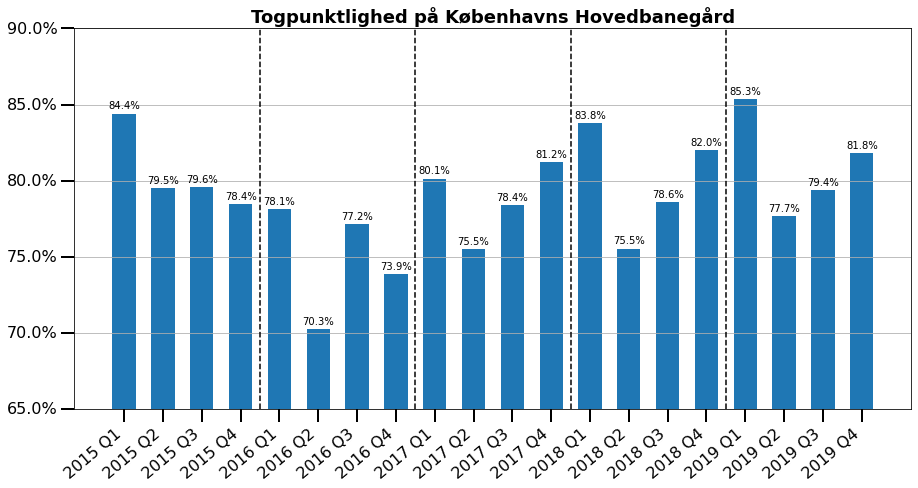

In [35]:
split_vars = ['Kvartal'] 
apply_vars = ['Togpunktlighed']
apply_fcts = ['mean']

df_illu = df_kbh.groupby(split_vars)[apply_vars].agg(apply_fcts)

x_labels = df_illu.index.get_level_values(0)
l_punkt = list(df_illu['Togpunktlighed']['mean'])

values = np.array(l_punkt)
x = range(len(values))

# plot
fig, ax = plt.subplots(figsize=(15,7))
rects = ax.bar(x, values, 0.6)#, color=['b', 'b', 'b', 'b', 'g', 'g', 'g', 'g'])

# labels på bar
for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# x-aksen
x_ticks = []
for i in range(len(x_labels)):
    x_ticks.append(i)
plt.xticks(x_ticks, x_labels, \
           rotation=40, \
           fontsize='16', \
           horizontalalignment='right', \
           verticalalignment='top')
plt.tick_params(axis='x', direction='out', length=13, width=2)

# y-aksen
plt.yticks(
          fontsize='16', \
          horizontalalignment='right', \
          verticalalignment='center')
plt.tick_params(axis='y', direction='out', length=13, width=2)

# zoom ind
plt.ylim([0.65, 0.9])

# vertikale linjer mellem hvert år
ax.plot([3.5, 3.5], [0.65, 0.9], "k--")
ax.plot([7.5, 7.5], [0.65, 0.9], "k--")
ax.plot([11.5, 11.5], [0.65, 0.9], "k--")
ax.plot([15.5, 15.5], [0.65, 0.9], "k--")

# tilføj grid
plt.grid(axis = 'y')

# omdan y-aksen til procent
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# tilføj titel
ax.set_title('Togpunktlighed på Københavns Hovedbanegård', \
             fontweight='bold', \
             fontsize='18')

## Sammenligning mellem Københavns Hovedbanegård og resten af DK
Københavns Hovedbanegård med resten af landet i perioden 2016-2019. Først findes værdierne fra Københavns Hovedbanegård:

In [36]:
#år der skal sammenlignes
year_list = [2016, 2017, 2018, 2019]

split_vars = ['Årstal'] 
apply_vars = ['Togpunktlighed']
apply_fcts = ['mean']

df_illu = df_kbh[df_kbh["Årstal"].isin(year_list) == True].groupby(split_vars)[apply_vars].agg(apply_fcts)

l_kbh = list(df_illu['Togpunktlighed']['mean'])

Dernæst findes værdierne i årrækken for hele Danmark:

In [37]:
split_vars = ['Årstal'] 
apply_vars = ['Punktlighed']
apply_fcts = ['mean']

df_illu = df_punktlighed[df_punktlighed["Årstal"].isin(year_list) == True].groupby(split_vars)[apply_vars].agg(apply_fcts)

l_dk = list(df_illu['Punktlighed']['mean'])

Værdierne kan nu sammenlignes ved illustration:

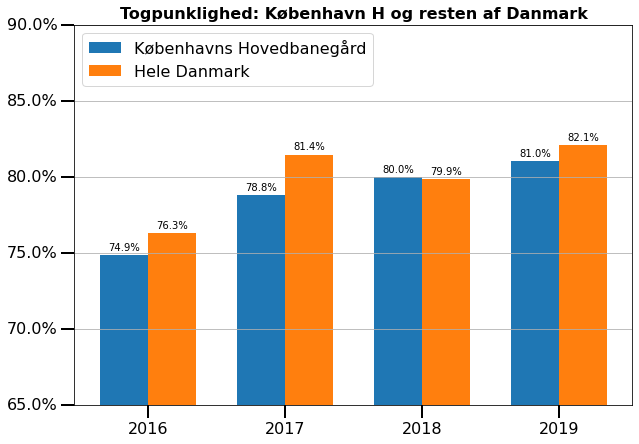

In [38]:
x_labels = df_illu.index.get_level_values(0)
values1 = np.array(l_kbh)
values2 = np.array(l_dk)
x = np.arange(len(x_labels))

width = 0.35

# plot
fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x-width/2, values1, width, label='Københavns Hovedbanegård')
rects2 = ax.bar(x+width/2, values2, width, label='Hele Danmark')

# funktion der tilføjer procent over søjlerne
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
        
# x-aksen
x_ticks = []
for i in range(len(x_labels)):
    x_ticks.append(i)
plt.xticks(x_ticks, x_labels, \
           fontsize='16', \
           horizontalalignment='center', \
           verticalalignment='top')
plt.tick_params(axis='x', direction='out', length=13, width=2)


# y-aksen
plt.yticks(
          fontsize='16', \
          horizontalalignment='right', \
          verticalalignment='center')
plt.tick_params(axis='y', direction='out', length=13, width=2)

# zoom ind
plt.ylim([0.65, 0.9])

# omdan y-aksen til procent
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

# tilføj grid
plt.grid(axis = 'y')

# tilføj titel
ax.set_title('Togpunklighed: København H og resten af Danmark', \
             fontweight='bold', \
             fontsize='16')

# tilføj legend
plt.legend(loc="upper left", prop={'size': 16})

## Passagertal
Data på passagertal øst for Storebælt importeres:

In [39]:
#datasættet importeres fra excel fil
df_passager = pd.read_excel("Passagertal øst for storebælt 2006-2021.xlsx",\
                           usecols="C:BL",\
                           skiprows=[1,4,5,6])\
                           .T

#inspiceres
df_passager

,0,1
Unnamed: 2,2006K1,8598
Unnamed: 3,2006K2,9143
Unnamed: 4,2006K3,9194
Unnamed: 5,2006K4,9465
Unnamed: 6,2007K1,8946
...,...,...
Unnamed: 59,2020K2,3760
Unnamed: 60,2020K3,6396
Unnamed: 61,2020K4,5369
Unnamed: 62,2021K1,3260
